## Import libraries

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from keras.optimizers import Adam

2025-10-28 09:38:14.167173: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-28 09:38:14.212205: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-28 09:38:16.105435: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load the dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"

columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
df = pd.read_csv(url, header=None, names=columns)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Preprocess the data

### Split into features and labels

In [3]:
X = df.iloc[:, 0:4].values # numerical features
y = df.iloc[:, 4].values # class labels (species)

### Convert text labels to numeric form

In [4]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)   # Setosa = 0, Versicolor = 1, Virginica = 2

> docs: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

### One-hot encode labels

We do this to convert the numeric class labels (0, 1, 2) into one-hot vectors like [1,0,0], [0,1,0], [0,0,1], because the neural network needs this format for multiclass classification with softmax.

In [5]:
y_onehot = to_categorical(y_encoded)

## Shuffle the data

If we don’t shuffle the data, the model might see many samples from the same class in sequence.
Then it can learn patterns in the order instead of real features, causing worse accuracy and slower or unstable learning.

In [6]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y_onehot = y_onehot[indices]

## Build the neural network

- One hidden layer (example: 8 neurons, ReLU activation),
- Output layer: 3 neurons, softmax activation.

In [7]:
model = Sequential([
    Dense(8, input_shape=(4,), activation='relu'),
    Dense(3, activation='softmax')
])

/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-28 09:38:18.146690: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


* 8 = the number of neurons in the hidden layer. It’s a small number that gives the model enough power to learn patterns without overfitting.
* ReLU = the activation function for the hidden layer. It keeps positive values and sets negative ones to 0.
* 3 = the number of output neurons, because there are 3 iris species to predict (Setosa, Versicolor, Virginica).
* Softmax = makes the 3 outputs become probabilities that sum to 1, one value for each clas.


## Compile the model

We use Adam because it is a smart optimizer that helps the model learn faster and more smoothly. It combines two ideas: momentum (it keeps moving in a good direction) and adaptive learning rate (it changes the step size automatically).

> https://www.reddit.com/r/reinforcementlearning/comments/ei9p3y/using_rmsprop_over_adam/

In [8]:
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )


opt = Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

This code shows that when we use the default optimizer, the accuracy is around 0.9.
So we create a new optimizer with a higher learning rate (0.01) using Adam.

This helps the model learn faster and reach higher accuracy, because it updates the weights with slightly bigger steps during training.

## Train the model

* epochs = 30: the model sees the whole dataset 30 times. That’s usually enough for it to learn without overfitting.
* batch_size = 16: the Iris dataset has only 150 samples, so a batch size of 16 or 32 is a good balance, the model sees enough data to learn patterns but not too much to lose training speed. I also tried a batch size of 8, but the results jumped a lot between runs.
* validation_split = 0.2: 20% of the data is kept for validation (to check how well the model works on unseen data).
* verbose = 1: means "show training progress." It prints the loss and accuracy for each epoch in the output.


In [9]:
history = model.fit(
    X, y_onehot,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3250 - loss: 1.7866 - val_accuracy: 0.3667 - val_loss: 1.1910
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4917 - loss: 1.0833 - val_accuracy: 0.4333 - val_loss: 0.9311
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6500 - loss: 0.8330 - val_accuracy: 0.6333 - val_loss: 0.8274
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6750 - loss: 0.7376 - val_accuracy: 0.6333 - val_loss: 0.7402
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6750 - loss: 0.6377 - val_accuracy: 0.6333 - val_loss: 0.6453
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6917 - loss: 0.5519 - val_accuracy: 0.6667 - val_loss: 0.5625
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8083 - loss: 0.4890 - val_accuracy: 0.8667 - val_loss: 0.5034
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8250 - loss: 0.4472 - val_accuracy: 0.8667 - val_loss: 0.4646
Epoch 9

## Visualize the training progress

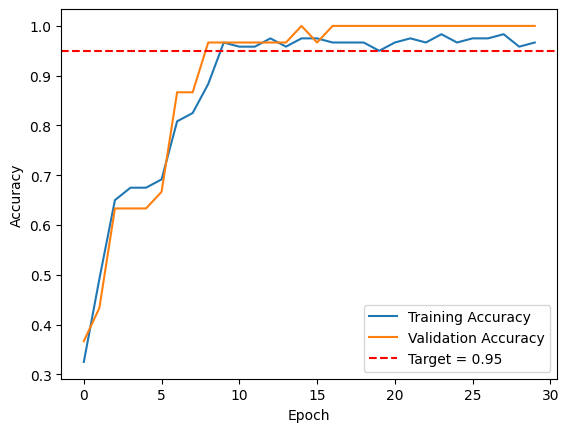

In [10]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.axhline(y=0.95, color='red', linestyle='--', label='Target = 0.95')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
